#####  Advanced Machine Learning Methods

Kevin Brandon Cruz Mejía 

## TC 5033
### Word Embeddings

<br>

#### Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested.

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%):
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


### Import libraries

In [1]:
!pip install 'portalocker>=2.0.0'

In [2]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F
from torch.nn.modules import rnn
import random
# Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [4]:
# Split the AG_NEWS dataset into training and test datasets.
train_dataset, test_dataset = AG_NEWS()

In [5]:
# Convert training and test datasets from an iterable dataset to a map style dataset.
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [6]:
# Retrieve a tokenizer function for English language
# 'basic_english' tokenizer will convert text to lowercase and split on spaces and punctuation
tokeniser = get_tokenizer('basic_english')

# Create a tokenizer function to tokenize text
def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)

In [7]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
# Sets the default index for the vocabulary,
#if a word is not found in the vocabulary, the index for "<unk>" is returned.
vocab.set_default_index(vocab["<unk>"])

In [8]:
#test tokens
tokens = tokeniser('Welcome to TE3007')
print(tokens, vocab(tokens))

['welcome', 'to', 'te3007'] [3314, 4, 0]


In [9]:
# Set the number of training samples as 90% of the total number of train_dataset
NUM_TRAIN = int(len(train_dataset)*0.9)

# Set the number of validation samples as 10%
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [10]:
# Split the train_dataset into two datasets: one for training and one for validation
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [11]:
# Print lenght for train, validation and test dataset
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


In [12]:
# function passed to the DataLoader to process a batch of data as indicated
def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))

    # Create list with indices from tokeniser
    x = [vocab(tokeniser(text)) for text in x]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return torch.tensor(x, dtype=torch.int32), torch.tensor(y, dtype=torch.int32) - 1

In [13]:
labels =  ["World", "Sports", "Business", "Sci/Tech"]
max_tokens = 50
BATCH_SIZE = 256

In [14]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

### Let us build our RNN model

In [15]:
EMBEDDING_SIZE = 300
NEURONS = 256
LAYERS = 2
NUM_CLASSES = 4

Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

In [16]:
# Define a class for the RNN model which inherits from nn.Module.
class RNN_Model_1(nn.Module):
    # Sets up the model architecture with the given parameters.
    def __init__(self, embed_size, hidden, layers, num_classes):

         # Initialize the superclass nn.Module
        super().__init__()

        # Turns word indexes into embeddings
        # len(vocab) specifies the total number of embeddings to create, one for each word.
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab),
                                            embedding_dim=embed_size)

        # GRU model used
        # input_size = size of the input
        # hidden_size = size of the model hidden section
        # num_layers = number of stacked layers
        # batch_first = indicates that the input will have the batch dimension first
        # bidirectional = the model will process the input in both directions
        self.rnn = nn.GRU(input_size = embed_size,
                          hidden_size = hidden,
                          num_layers = layers,
                          batch_first = True,
                          bidirectional= True)

        # FCN that maps the RNN outputs to the number of classes
        # 2*hidden is used because the GRU is bidirectional, so it concatenates the hidden states from both directions
        self.fc = nn.Linear(in_features=2*hidden,out_features=num_classes)

    # Fordward propagation function
    def forward(self, x):

        # Pass the input through the embedding layer
        vector_embs = self.embedding_layer(x)

        # Pass the embeddings to the GRU layer
        # 'y' are the output features from the last layer of the GRU for each timestep
        # 'h' are the hidden states for each layer at the last timestep
        y,h = self.rnn(vector_embs)

        # Pass the final output features through the fully connected layer
        # selects the data from the last timestep of the GRU model
        return self.fc(y[:,-1])

Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

In [17]:
# Define a function to calculate accuracy
def accuracy(model, loader):

    #Switch the model to evaluation mode
    model.eval()

    # Move the model to the appropriate device CPU or GPU
    model = model.to(device = device)

    # Initialize 'correct' as a counter for the number of correct predictions
    # Initialize  'total' as a counter for the total number of samples processed
    correct = 0
    total = 0

    # Disable gradient computation not needed during model evaluation
    with torch.no_grad():

        # Loop over all batches of data in loader.
        for data in loader:

            # Loads input data and labels in the device
            inputs, labels = data[0].to(device), data[1].to(device)

             # Pass the input data to the model to get predictions
            outputs = model(inputs)

            # Search the class with the highest predicted probability
            _, predicted = torch.max(outputs, 1)

            # Increment the total count by the number of samples in the current batch
            total += labels.size(0)

            # Increment the correct count by the number of accurately predicted samples in the current batch
            correct += (predicted == labels).sum().item()

    # Calculate the accuracy as the percentage of correct predictions out of all samples
    accuracy = 100 * correct / total
    return accuracy

Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

In [18]:
# Define a function for training
def train(model, optimiser, epochs=100):

    # Move the model to the device GPU or CPU
    model.to(device)

    # Initialize the loss function CrossEntropyLos
    criterion = torch.nn.CrossEntropyLoss()

    # Loop over the dataset the number of epochs
    for epoch in range(epochs):

        # Set the model to training mode
        model.train()
        # Initialize  running_loss to track the loss over each epoch
        running_loss = 0.0

        # Loop over all batches in train_loader
        for i, data in enumerate(train_loader, 0):

            # Load the current batch and labels in the device.
            inputs, labels = data[0].to(device), data[1].to(device)

            # Clear out gradients of before the forward pass
            optimiser.zero_grad()

            # Forward pass: Calculates the predicted outputs
            outputs = model(inputs)

            # Calculates the batch loss using CrossEntropyLoss
            loss = criterion(outputs, labels.long())

            # Perform a backward pass
            loss.backward()

            # Perform optimization step to update the model parameters
            optimiser.step()

            # Add the loss over all batches to get the total loss for the epoch
            running_loss += loss.item()

        # Calculates the accuracy of the model in the validation dataset
        acc = accuracy(model, val_loader)

        # Print the epoch number, loss of the epoch and the validation accuracy
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}, Accuracy:{acc}')

In [19]:
# Set number of epochs
epochs = 10

# Set the learning rate
lr = 0.001

# Instantiate model
rnn_model = RNN_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES)

# Initialize Adam optimizer with the model parameters and learning rate
optimiser = torch.optim.Adam(rnn_model.parameters(), lr=lr)

In [20]:
#Train the model
train(rnn_model, optimiser=optimiser,  epochs=epochs)

Epoch 1, Loss: 0.5602503716239432, Accuracy:90.2
Epoch 2, Loss: 0.21993088847582373, Accuracy:91.49166666666666
Epoch 3, Loss: 0.14022696504625382, Accuracy:91.79166666666667
Epoch 4, Loss: 0.0861948731121435, Accuracy:91.85833333333333
Epoch 5, Loss: 0.05112613625692036, Accuracy:91.70833333333333
Epoch 6, Loss: 0.03093351052866551, Accuracy:91.50833333333334
Epoch 7, Loss: 0.022898591979808435, Accuracy:91.78333333333333
Epoch 8, Loss: 0.017310135392582495, Accuracy:91.39166666666667
Epoch 9, Loss: 0.01583736403792836, Accuracy:91.56666666666666
Epoch 10, Loss: 0.01301896704335463, Accuracy:90.91666666666667


From the epoch list, it is possible to determine that after epoch 5 the model training starts to oscilate that means the the model with the selected parameters cannot improve the accuracy, however 90% is a good accuracy result.

Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

In [21]:
def sample_text(model,loader):
    # Switch model to evaluation mode
    model.to(device)
    model.eval()

    # Selects randomly a text from the test dataset
    sample_index = random.randint(0, len(test_dataset) - 1)
    label, text = test_dataset[sample_index]

    # Tokenize the text
    tokens = vocab(tokeniser(text))

    # Implement pad or truncate the sequence to max_tokens
    if len(tokens) < max_tokens:
        tokens += [0] * (max_tokens - len(tokens))
    else:
        tokens = tokens[:max_tokens]  # truncate

    # Convert tokens to a tensor
    tokens_tensor = torch.tensor(tokens, dtype=torch.int32).unsqueeze(0).to(device)

    # Get predictions
    with torch.no_grad():
        output = model(tokens_tensor)
        prediction = output.argmax(1).item()

    # Get the actual and predicted labels
    predicted_label = labels[prediction]

    # Subtract 1 because labels are 1-indexed in AG_NEWS
    actual_label = labels[label - 1]

    # Print the sample text, predicted label, and actual label
    print(f'Text: {text}')
    print(f'Predicted label: {predicted_label}')
    print(f'Actual label: {actual_label}')

Try 1

In [22]:
sample_text(rnn_model, test_dataset)

Text: Fierce Clashes in Iraq Kill 36; 203 Hurt US troops battled Shiite militiamen loyal to rebel cleric Muqtada al-Sadr in the Baghdad slum of Sadr City on Tuesday in fierce fighting that killed 36 people, including 
Predicted label: World
Actual label: World


Try 2

In [24]:
sample_text(rnn_model, test_dataset)

Text: News: Report card day looms for federal agencies Cyber security audits find improvement in some agencies, but viruses and worms still plague the halls of government.\ 
Predicted label: Sci/Tech
Actual label: Sci/Tech


Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

In [25]:
def disp_confusion_matrix(model, test_loader):
    # Model in evaluation mode
    model.to(device)
    model.eval()
    # Lists to store the true labels and the predictions
    true_targets = []
    predictions = []


    with torch.no_grad():
        for inputs, labels in test_loader:
            # Transfer inputs and labels to the device (CPU/GPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Get model predictions
            outputs = model(inputs)

            # Get the index of the max log-probability as the prediction
            _, predicted = torch.max(outputs, 1)

            # Store true labels
            true_targets.extend(labels.cpu().numpy())

            # Store predictions
            predictions.extend(predicted.cpu().numpy())

    # Generate the confusion matrix using the true targets and predictions
    cm = confusion_matrix(true_targets, predictions)

    # Visualize the confusion matrix using a heatmap
    fig, ax = plt.subplots(figsize=(8,8))

    # Create a heatmap with the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Greens, cbar=False)

    # Label the axes with the correct class labels
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    # Set the class labels as tick labels on the x and y axis
    class_labels = ["World","Sports","Business","Sci/Tech"]
    ax.set_xticklabels(class_labels)
    ax.set_yticklabels(class_labels)

    # Title for the heatmap
    plt.title('Confusion Matrix')
    plt.show()

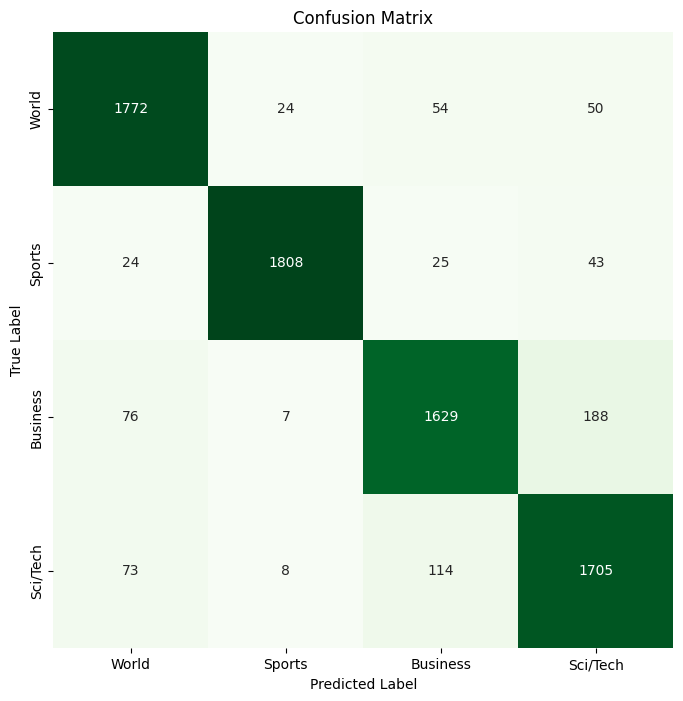

In [26]:
disp_confusion_matrix(rnn_model, test_loader)